# KODLUYORUZ K136 İSTANBUL VERİ BİLİMİ BOOTCAMP

## GRUP 6 - KADIKÖY BÖLGESİ İÇİN UYGUN İSBİKE NOKTALARININ BELİRLENMESİ

### Kütüphanelerin Eklenmesi ve Class'ların Tanımlanması

#### Kütüphanelerin Eklenmesi

In [1]:
# Colab'i Drive'a bağlama
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
#!pip install geopandas        # Colab için
#!pip install shapely          # Colab için
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import folium
from shapely.geometry import Point

#### Kadıköy Geojson Verisinin Alınması ve Temizlenmesi

In [3]:
kadikoy = gpd.read_file(r"..\Data\KadikoyMap.geojson")                                     # Lokal için
#kadikoy = gpd.read_file("/content/drive/MyDrive/Bootcamp-Grup6/KadikoyMap.geojson")       # Colab için
# Gereksiz bilgilerin silinmesi. Birden fazla coğrafi veri ile ilgili satır içerdiğinden ilk 21 tanesi yeterlidir. 
kadikoy = kadikoy.iloc[:21]

#### DrawMap Fonksiyonu (Base Map üzerine geojson noktalarının çizdirilmesi)

In [4]:
def DrawMap(act, title, district=kadikoy):
    """ 
    Parametre olarak act, title ve district alır. 
    act = geojson, title = çizilen haritanın başlığı, district (default = kadikoy) = çizdirilecek olan bölge
    Çıktı olarak ilgili Base Map üzerine ilgili geojson noktalarını çizdirir.
    """
    fig, ax = plt.subplots(figsize=(15, 15))
    district.plot(ax=ax)
    act.plot(ax=ax, color="red")
    ax.set_title(title, fontdict={'fontsize': 30})
    ax.set_ylabel('Latitude', fontdict={'fontsize': 20})
    ax.set_xlabel('Longitude', fontdict={'fontsize': 20})

#### CentAndLatLot Fonksiyonu (Modele sokmadan önce koordinatların düzenlenmesi)

In [5]:
# K-means modeline sokmadan önce koordinatların çıkarılması
def CentAndLatLot(dataframe):
    """
    Parametre olarak df alır. 
    dataframe'i k-means modeline sokmandan önce koordinatları ayarlar. 
    dataframe'i return eder.
    """
    for i in range(len(dataframe)):
        dataframe.geometry[i] = dataframe.geometry[i].centroid

    dataframe["lat"] = "none"
    dataframe["lon"] = "none"

    for i in range(len(dataframe)):
        dataframe.lat[i] = dataframe.geometry[i].x
        dataframe.lon[i] = dataframe.geometry[i].y

    dataframe = dataframe.astype({"lat": float}, errors='raise')
    dataframe = dataframe.astype({"lon": float}, errors='raise')

    return dataframe

#### ClusterNum Fonksiyonu (Cluster sayısının belirlenmesi)

In [6]:
# K-means için gerekli cluster sayısının belirlenmesi
def ClusterNum(dataframe, weighted='weight'):
    """
    Parametre olarak dataframe, weighted alır.
    K-means modeli için gerekli olan cluster sayısını belirler.
    Çıktı olarak Elbow metodu çizdirir.
    """
    x = dataframe[["lon", "lat"]]
    wcss = []
    for i in range(1, 10):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(x, sample_weight=dataframe[weighted])
        wcss.append(kmeans.inertia_)
    plt.plot(range(1, 10), wcss)
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()


#### ClusterModel Fonksiyonu (K-means modelini oluşturan ve merkezleri belirleyen fonksiyon)

In [7]:
# K-means modelini oluşturan ve cluster'ların merkezlerini belirleyen fonksiyon
def ClusterModel(noc, dataframe, weighted='weight'):
    """
    Parametre olarak noc, dataframe, weighted alır. 
    noc = cluster sayısı (int), dataframe = dataframe, weighted (default = "weight") = ağırlık
    Çıktı olarak dtf_X (noktaların lat, lon ve ait olduğu cluster) ve center (cluster noktalarının lat ve lon'u) döndürür.
    """
    x = dataframe[["lat", "lon"]]
    model = KMeans(n_clusters=noc, init='k-means++', max_iter=300, n_init=10, random_state=0)

    dtf_X = x.copy()
    dtf_X["cluster"] = model.fit_predict(x, sample_weight=dataframe[weighted])

    center = model.cluster_centers_
    return [dtf_X, center]

#### ClusterMap Fonksiyonu (Cluster'ların ve cluster merkezlerinin Base Map'te çizdirilmesi.)

In [8]:
# Model kurulumu sonrası cluster'ların ve cluster merkezlerinin haritada gösterilmesi
def ClusterMap(model, center, district=kadikoy):
    """
    Cluster'ların ve cluster merkezlerinin Base Map'te çizdirilmesi.
    Parametre olarak model, center, district (default = kadikoy) alır. 
    Çıktı olarak Base Map üzerinde cluster'lar ve cluster merkezlerini çizdirir.
    """
    fig, ax = plt.subplots(figsize=(15, 15))
    district.plot(ax=ax, color="powderblue")
    model.plot.scatter(ax=ax, x='lat', y='lon', c="cluster", s=50, cmap='Accent_r')
    plt.scatter(center[:, 0], center[:, 1], c='red', s=200, alpha=0.5)


#### DrawRealMap Fonksiyonu (Cluster'ların gerçek harita üzerinde gösterilmesi)




In [9]:
# Cluster'ların Open Street Map üzerinde gösterilmesi 
def DrawRealMap(centers, color):
    """
    Cluster'ların gerçek harita üzerinde gösterilmesi.
    Parametre olarak centers, color alır. 
    Çıktı olarak gerçek harita üzerinde cluster'ları gösterir.
    """
    map = folium.Map(location=[40.98664398, 29.08949883], zoom_start=12)
    for c in centers:
        folium.Marker(
            location = [c[1], c[0]],
            icon = folium.Icon(color=color),
            popup = f'<b>Cluster Point</b><br>lat:{c[1]}, lon:{c[0]}',
            tooltip = "Click for more"
        ).add_to(map)
    #display(map)
    return map

### Haritaların Oluşturulması

#### Kadıköy Mahalleleri Haritasının Oluşturulması

Text(0.5, 163.20501922395357, 'Longitude')

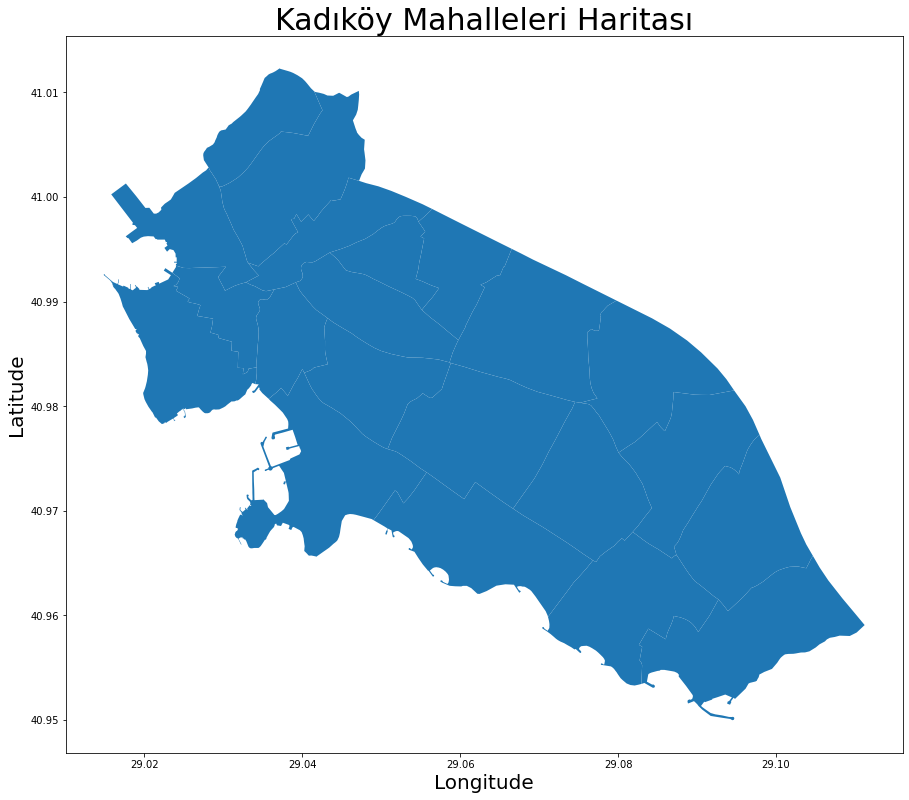

In [10]:
fig, ax = plt.subplots(figsize=(15, 15))
kadikoy.plot(ax=ax)
ax.set_title('Kadıköy Mahalleleri Haritası', fontdict={'fontsize': 30})
ax.set_ylabel('Latitude', fontdict={'fontsize': 20})
ax.set_xlabel('Longitude', fontdict={'fontsize': 20})

#### Kadıköy Yoğunluk Haritası

In [11]:
# Kadıköy mahalle nüfusunun alınması
df = pd.read_excel(open(r"..\Data\KadikoyNeighborhoodPopulations.xlsx", 'rb'))                             # Lokal için
#df = pd.read_excel("/content/drive/MyDrive/Bootcamp-Grup6/KadikoyNeighborhoodPopulations.xlsx")           # Colab için

# kadikoy ile df birleştiriliyor
df_kadikoy = pd.merge(kadikoy, df, how='inner', on='name')

# Population'a göre ağırlıklı model oluşturmak için
df_kadikoy_den = CentAndLatLot(df_kadikoy)

C:\Users\akdem\AppData\Local\Temp\ipykernel_8760\154699418.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.lat[i] = dataframe.geometry[i].x
C:\Users\akdem\AppData\Local\Temp\ipykernel_8760\154699418.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.lon[i] = dataframe.geometry[i].y


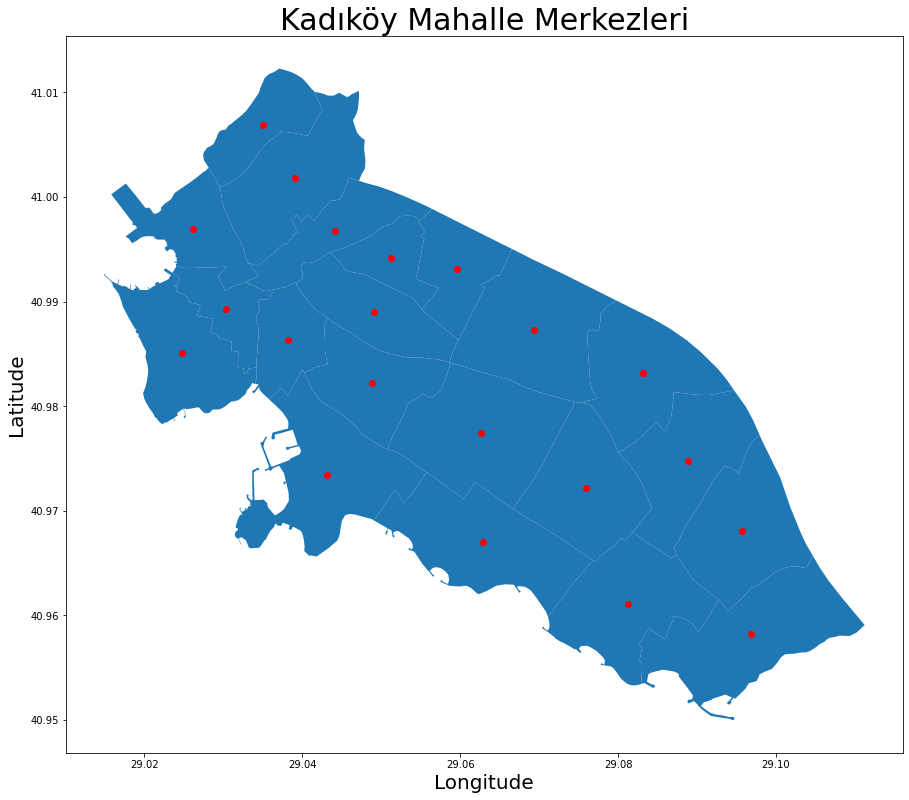

In [12]:
DrawMap(df_kadikoy_den, "Kadıköy Mahalle Merkezleri")

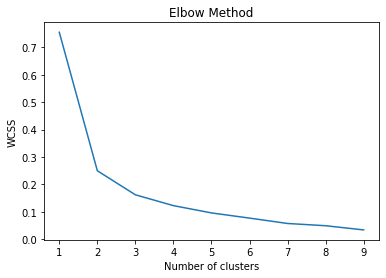

In [13]:
# Population density için Elbow
ClusterNum(df_kadikoy_den, weighted="density")

In [14]:
# Kadıköy density model
density_model, density_center = ClusterModel(3, df_kadikoy_den, weighted="density")

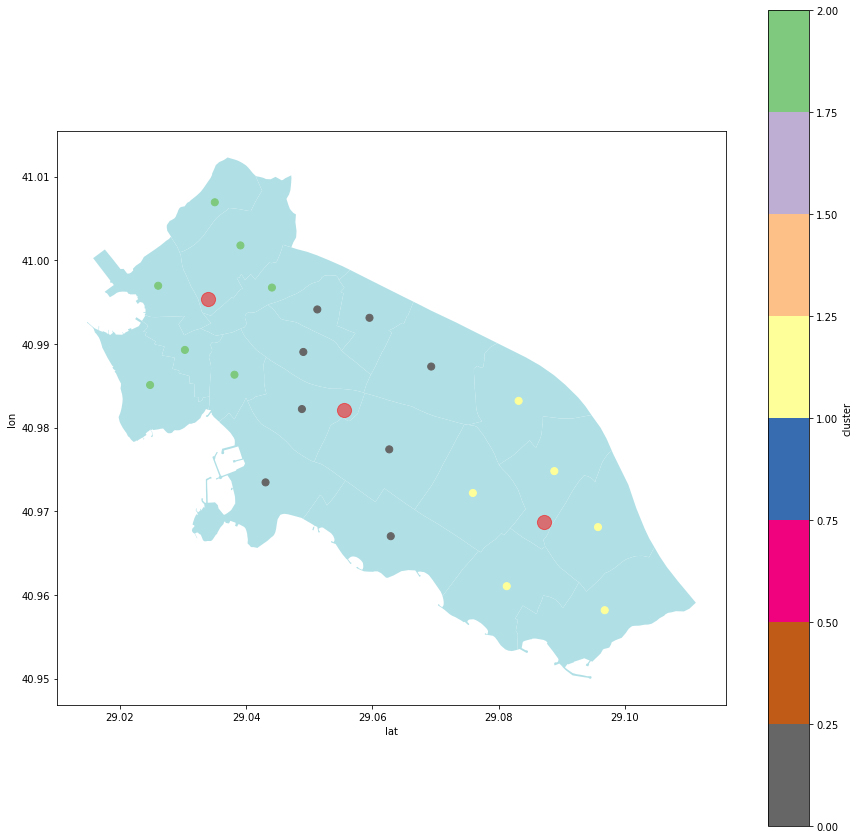

In [15]:
ClusterMap(density_model, density_center)

In [16]:
# Kadıköy nüfusa göre model
DrawRealMap(density_center, "green")

#### Kadıköy Toplu Taşıma İstasyonları Haritası

C:\Users\akdem\AppData\Local\Temp\ipykernel_8760\752498659.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  public_trans = bus.append(pt, ignore_index=True)


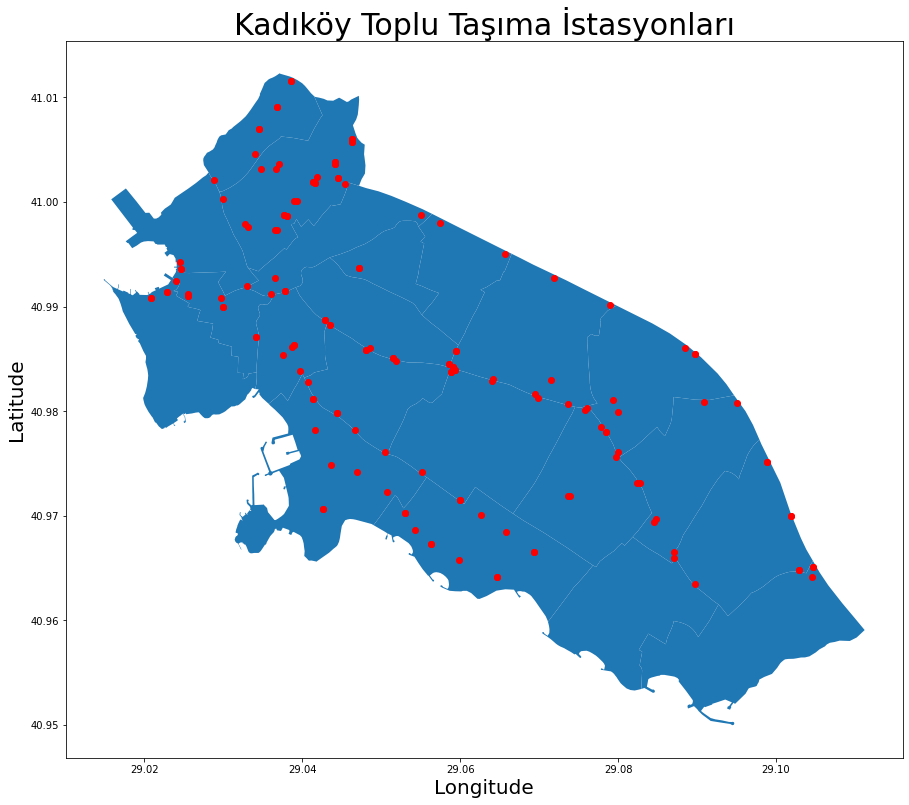

In [17]:
bus = gpd.read_file('..\Data\BusStations.geojson')                                            # Lokal için
pt = gpd.read_file('..\Data\PublicTransport.geojson')                                         # Lokal için
#bus = gpd.read_file('/content/drive/MyDrive/Bootcamp-Grup6/BusStations.geojson')             # Colab için
#pt = gpd.read_file('/content/drive/MyDrive/Bootcamp-Grup6/PublicTransport.geojson')          # Colab için


for i in range(len(pt)):
    pt.geometry[i] = bus.geometry[i].centroid

public_trans = bus.append(pt, ignore_index=True)
DrawMap(public_trans, "Kadıköy Toplu Taşıma İstasyonları")

In [18]:
public_trans = CentAndLatLot(public_trans)
public_trans['weight'] = 1

C:\Users\akdem\AppData\Local\Temp\ipykernel_8760\154699418.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.lat[i] = dataframe.geometry[i].x
C:\Users\akdem\AppData\Local\Temp\ipykernel_8760\154699418.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.lon[i] = dataframe.geometry[i].y


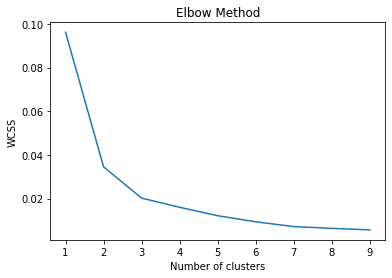

In [19]:
# Public_trans için cluster sayısının belirlenmesi
ClusterNum(public_trans)

In [20]:
# public_trans için oluşturulmuş model ve cluster merkezleri 
public_model, public_center = ClusterModel(3, public_trans)

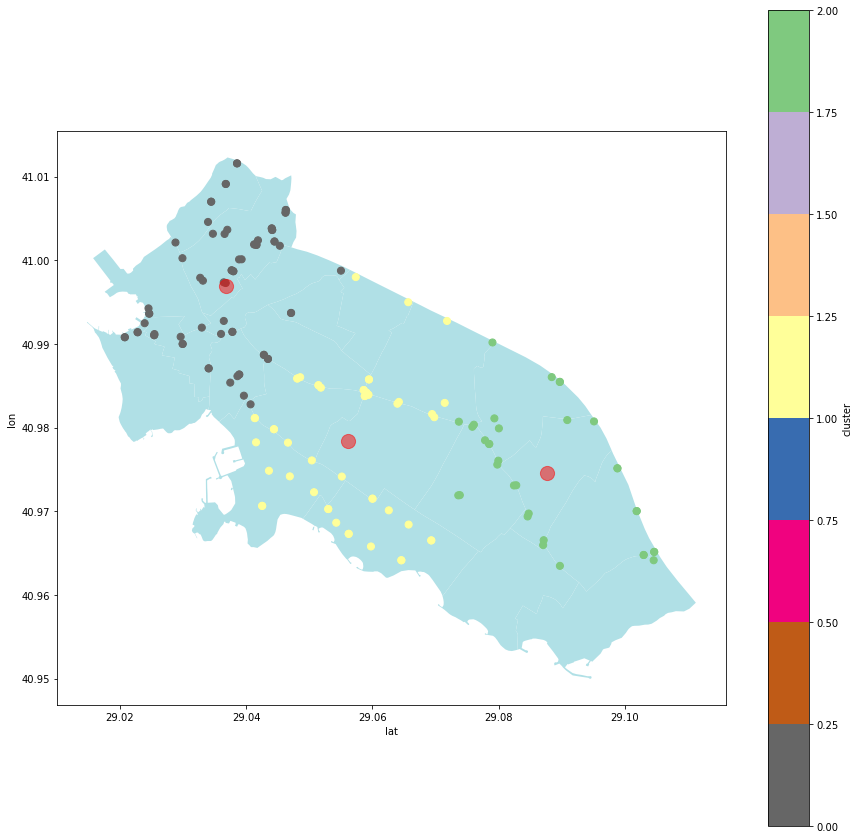

In [21]:
ClusterMap(public_model, public_center)

In [22]:
# public_center'ın gerçek haritada çizdirilmesi
DrawRealMap(public_center, "red")

#### Kadıköy Park Haritası

In [23]:
park = gpd.read_file('..\Data\Park.geojson')                                       # Lokal için
#park = gpd.read_file('/content/drive/MyDrive/Bootcamp-Grup6/Park.geojson')        # Colab için
park["AreaSize"] = park.area

C:\Users\akdem\AppData\Local\Temp\ipykernel_8760\2776598900.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  park["AreaSize"] = park.area


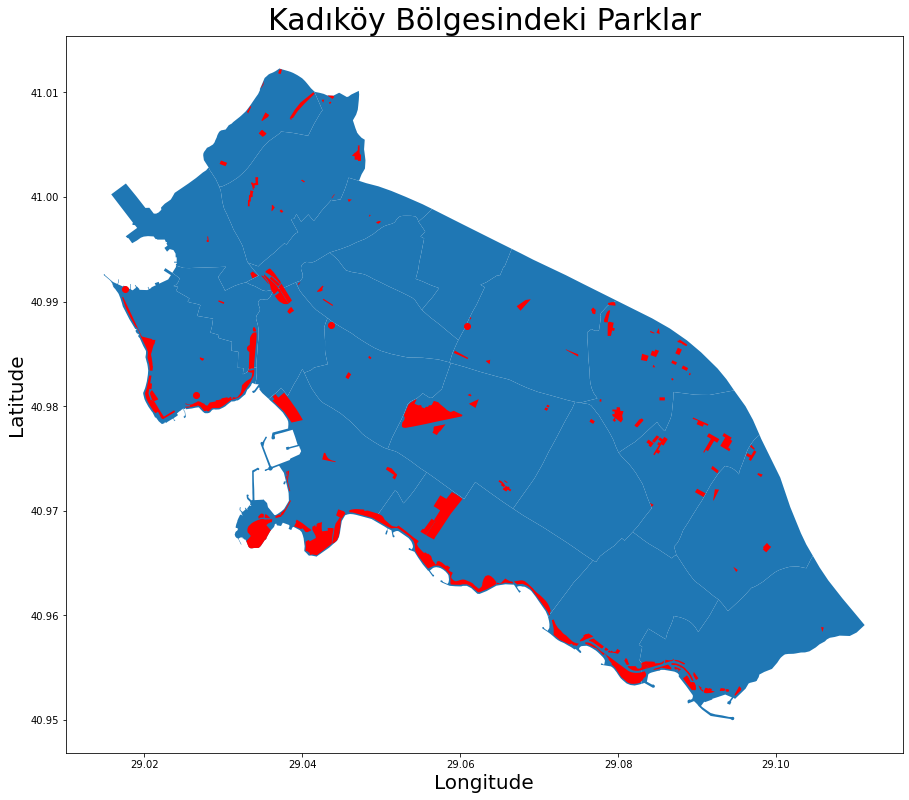

In [24]:
# Kadıköy'deki parkların çizimi
DrawMap(park, "Kadıköy Bölgesindeki Parklar")

In [25]:
park = CentAndLatLot(park)

C:\Users\akdem\AppData\Local\Temp\ipykernel_8760\154699418.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.lat[i] = dataframe.geometry[i].x
C:\Users\akdem\AppData\Local\Temp\ipykernel_8760\154699418.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.lon[i] = dataframe.geometry[i].y


In [26]:
park_model, park_center = ClusterModel(6, park, weighted="AreaSize")

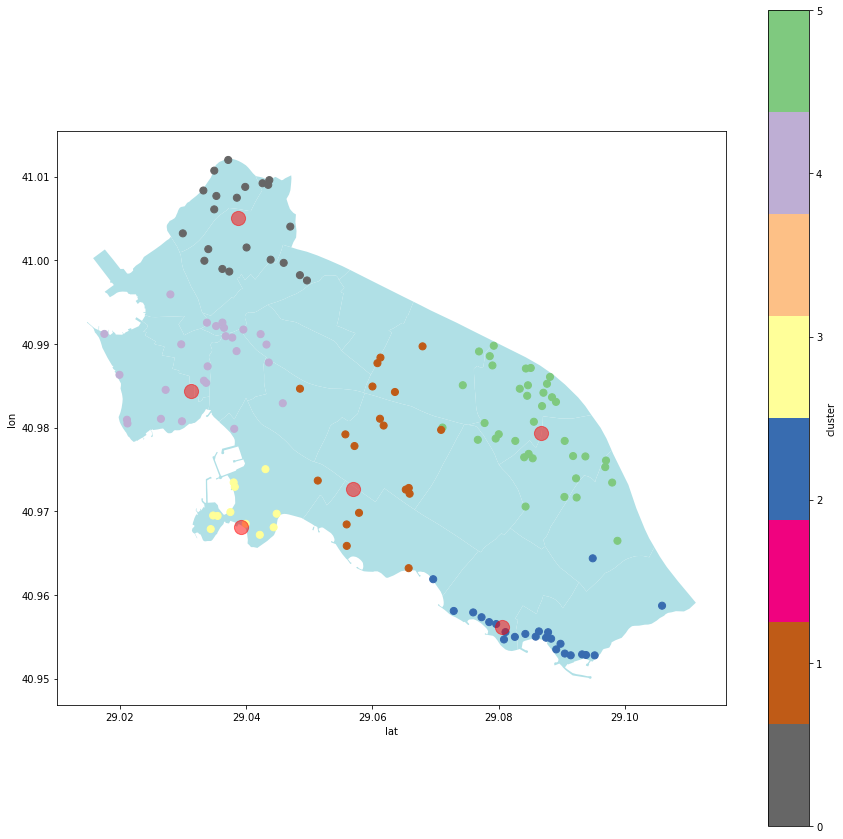

In [27]:
ClusterMap(park_model, park_center)

In [28]:
DrawRealMap(park_center, "green")

#### Kadıköy Alışveriş Merkezleri Haritası

In [29]:
sh_mall = gpd.read_file('..\Data\ShoppingMall.geojson')                                    # Lokal için
#sh_mall = gpd.read_file('/content/drive/MyDrive/Bootcamp-Grup6/ShoppingMall.geojson')     # Colab için
sh_mall["AreaSize"] = sh_mall.area

C:\Users\akdem\AppData\Local\Temp\ipykernel_8760\2429093729.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sh_mall["AreaSize"] = sh_mall.area


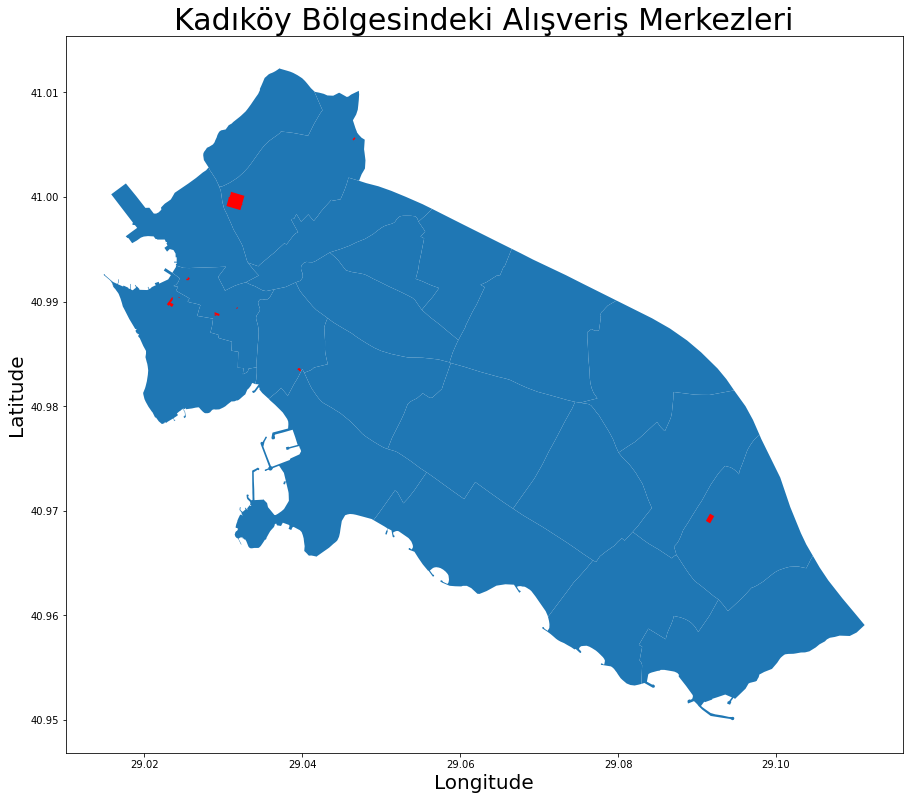

In [30]:
DrawMap(sh_mall, "Kadıköy Bölgesindeki Alışveriş Merkezleri")

In [31]:
sh_mall = CentAndLatLot(sh_mall)

C:\Users\akdem\AppData\Local\Temp\ipykernel_8760\154699418.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.lat[i] = dataframe.geometry[i].x
C:\Users\akdem\AppData\Local\Temp\ipykernel_8760\154699418.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.lon[i] = dataframe.geometry[i].y


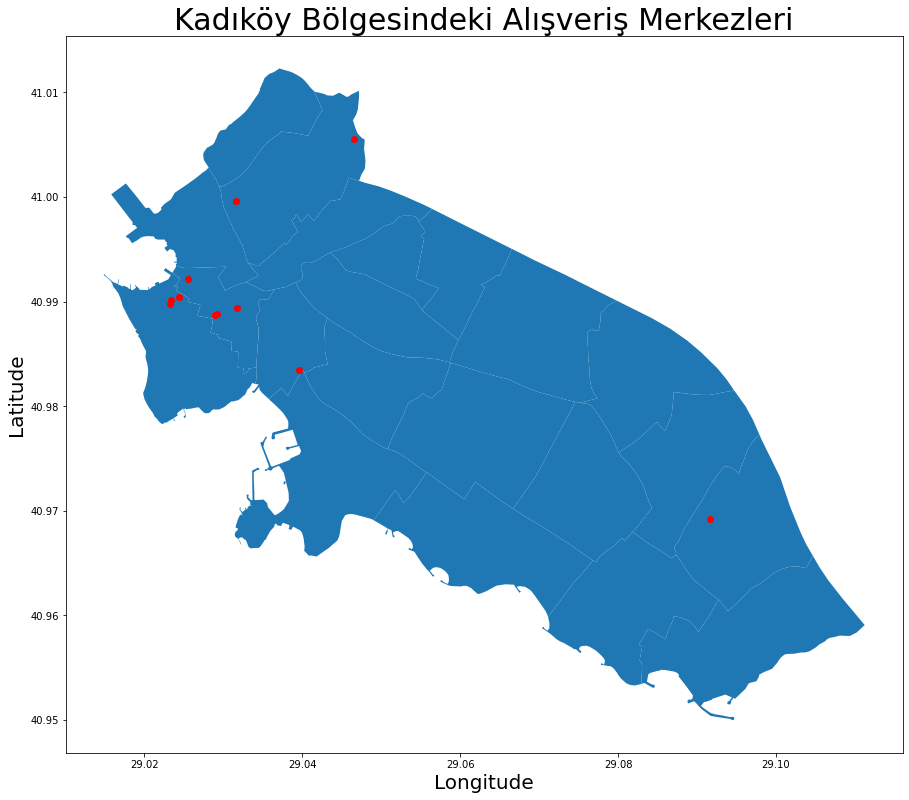

In [32]:
DrawMap(sh_mall, "Kadıköy Bölgesindeki Alışveriş Merkezleri")

In [33]:
sh_mall = CentAndLatLot(sh_mall)

C:\Users\akdem\AppData\Local\Temp\ipykernel_8760\154699418.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.lat[i] = dataframe.geometry[i].x
C:\Users\akdem\AppData\Local\Temp\ipykernel_8760\154699418.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.lon[i] = dataframe.geometry[i].y


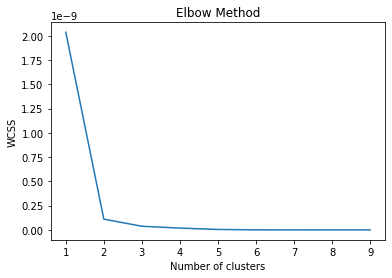

In [34]:
ClusterNum(sh_mall, weighted="AreaSize")

In [35]:
shop_model, shop_center = ClusterModel(2, sh_mall, weighted="AreaSize")

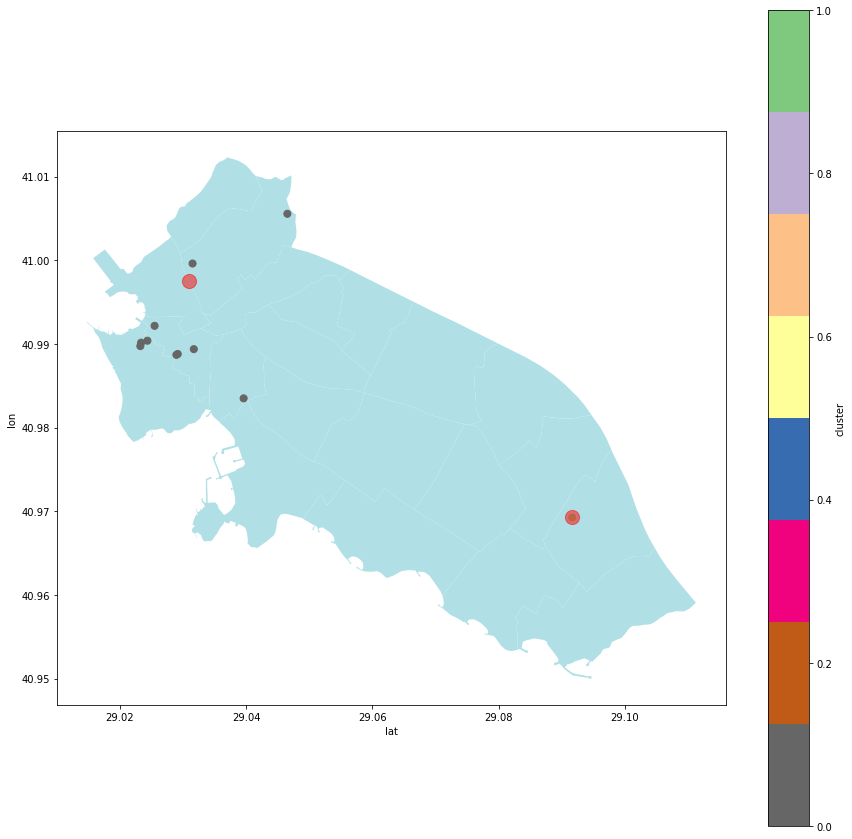

In [36]:
ClusterMap(shop_model, shop_center)

In [37]:
DrawRealMap(shop_center, "gray")

#### Kadıköy Eğitim Alanları Haritası

In [38]:
uni = gpd.read_file(r'..\Data\University.geojson')                                   # Lokal için
eduNode = gpd.read_file(r'..\Data\School.geojson')                                   # Lokal için
#uni = gpd.read_file('/content/drive/MyDrive/Bootcamp-Grup6/University.geojson')     # Colab için
#eduNode = gpd.read_file('/content/drive/MyDrive/Bootcamp-Grup6/School.geojson')     # Colab için

eduNode = eduNode.append(uni, ignore_index=True)
eduNode['weight'] = 1

C:\Users\akdem\AppData\Local\Temp\ipykernel_8760\2046903130.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  eduNode = eduNode.append(uni, ignore_index=True)


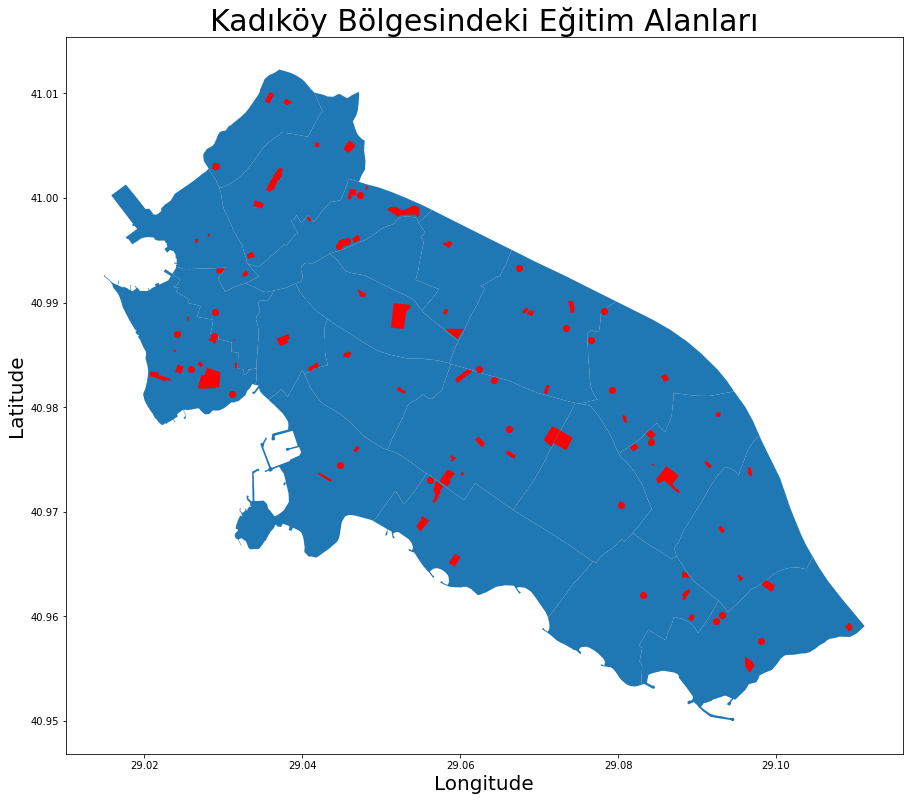

In [39]:
DrawMap(eduNode, "Kadıköy Bölgesindeki Eğitim Alanları")

In [40]:
eduNode = CentAndLatLot(eduNode)

C:\Users\akdem\AppData\Local\Temp\ipykernel_8760\154699418.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.lat[i] = dataframe.geometry[i].x
C:\Users\akdem\AppData\Local\Temp\ipykernel_8760\154699418.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.lon[i] = dataframe.geometry[i].y


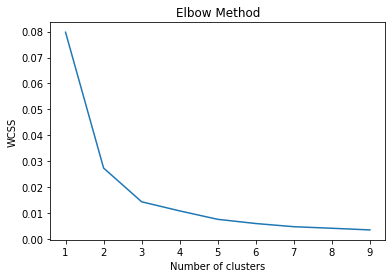

In [41]:
ClusterNum(eduNode)

In [42]:
edu_model, edu_center = ClusterModel(3, eduNode)

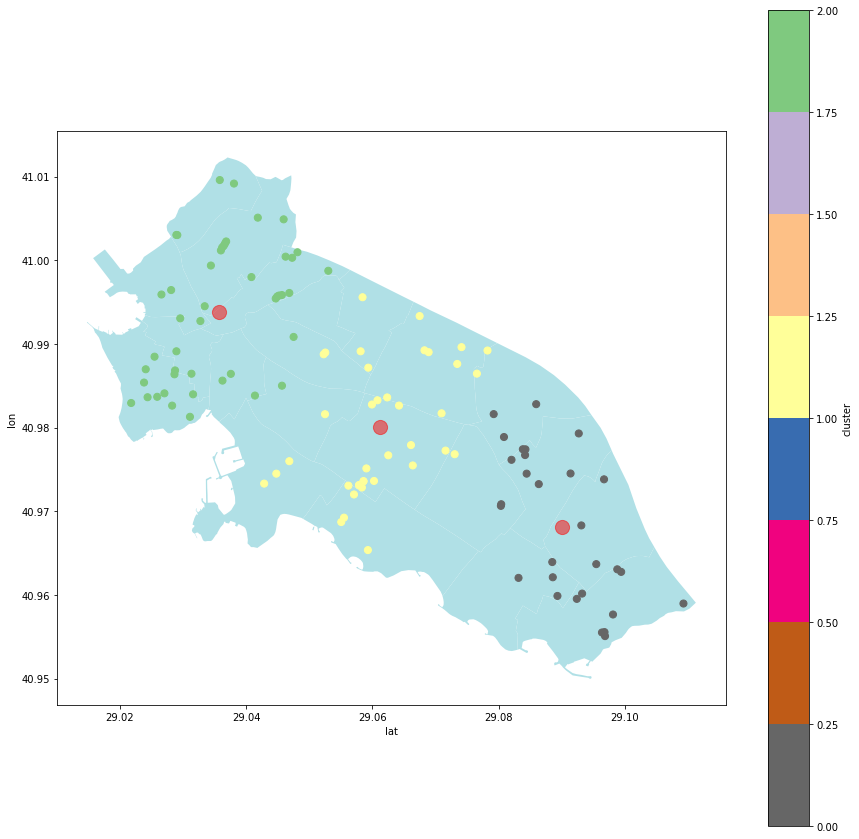

In [43]:
ClusterMap(edu_model, edu_center)

In [44]:
DrawRealMap(edu_center, "blue")

#### Tüm Merkezlerin Birleştirilmesi

In [45]:
arr = np.concatenate((public_center, density_center, park_center, shop_center, edu_center))

In [46]:
# Center'lari dataframe haline getirme
df_center = pd.DataFrame(arr, columns=['lat', 'lon'])
df_center['name'] = ['public_center', 'public_center', 'public_center', 
                     'density_center', 'density_center', 'density_center', 
                     'park_center', 'park_center', 'park_center', 'park_center', 
                     'park_center', 'park_center', 'shop_center', 'shop_center', 
                     'edu_center', 'edu_center', 'edu_center']

In [47]:
# Ağırlık kolonunu oluşturma
df_center['weight'] = 1.0
for i in range(len(df_center)):
    if df_center.iloc[i, 2] == "public_center":
        df_center.weight[i] = 0.526529232848935
    elif df_center.iloc[i, 2] == "density_center":
        df_center.weight[i] = 0.127407908077053
    elif df_center.iloc[i, 2] == "park_center":
        df_center.weight[i] = 0.159175397093613
    elif df_center.iloc[i, 2] == "shop_center":
        df_center.weight[i] = 0.0594795539033457
    elif df_center.iloc[i, 2] == "edu_center":
        df_center.weight[i] = 0.127407908077053


C:\Users\akdem\AppData\Local\Temp\ipykernel_8760\3052033069.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_center.weight[i] = 0.526529232848935
C:\Users\akdem\AppData\Local\Temp\ipykernel_8760\3052033069.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_center.weight[i] = 0.127407908077053
C:\Users\akdem\AppData\Local\Temp\ipykernel_8760\3052033069.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_center.weight[i] = 0

In [48]:
geometry = [Point(xy) for xy in zip(df_center.lon, df_center.lat)]
df2 = df_center.copy()
#df2 = df2.drop(['lon', 'lat'], axis=1)
gdf2 = GeoDataFrame(df2, crs="EPSG:4326", geometry=geometry)
gdf2

,lat,lon,name,weight,geometry
0,29.036810,40.996919,public_center,0.526529,POINT (40.99692 29.03681)
1,29.056177,40.978388,public_center,0.526529,POINT (40.97839 29.05618)
2,29.087633,40.974600,public_center,0.526529,POINT (40.97460 29.08763)
3,29.055591,40.982105,density_center,0.127408,POINT (40.98211 29.05559)
4,29.087112,40.968717,density_center,0.127408,POINT (40.96872 29.08711)
5,29.034058,40.995365,density_center,0.127408,POINT (40.99536 29.03406)
6,29.038719,41.005097,park_center,0.159175,POINT (41.00510 29.03872)
7,29.056970,40.972618,park_center,0.159175,POINT (40.97262 29.05697)
8,29.080614,40.956207,park_center,0.159175,POINT (40.95621 29.08061)
9,29.039249,40.968101,park_center,0.159175,POINT (40.96810 29.03925)


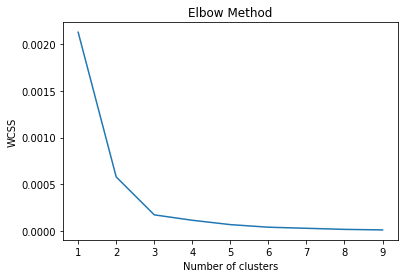

In [49]:
ClusterNum(df_center)

In [50]:
center_model, center_center = ClusterModel(3, df_center)

#### Belirlenen İsbike Noktaların Harita Üzerinde Gösterilmesi

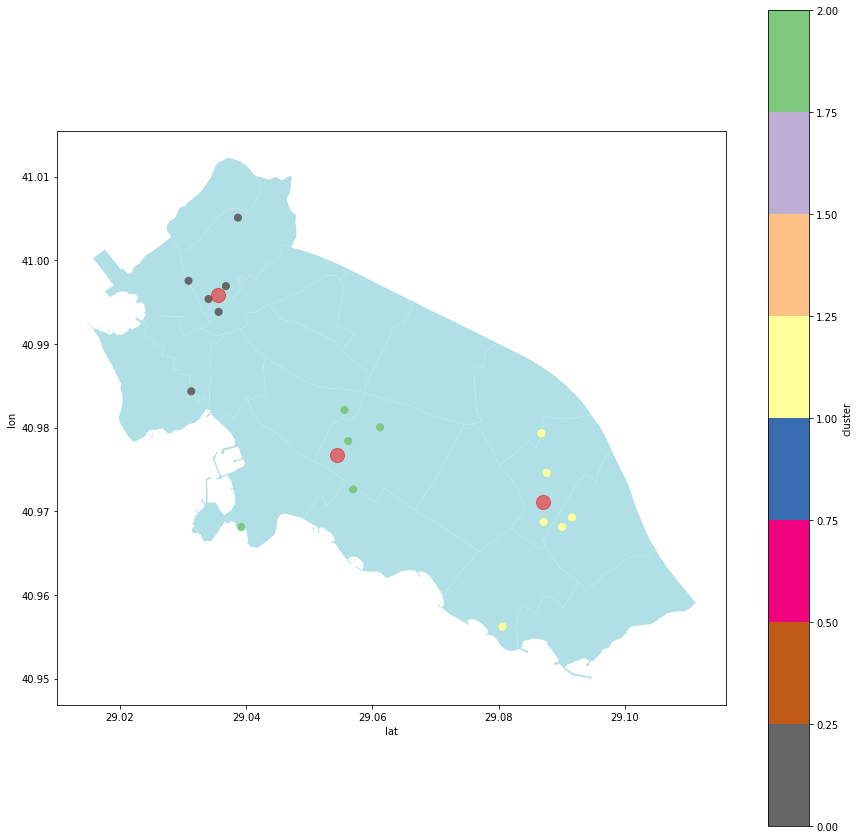

In [51]:
ClusterMap(center_model, center_center)

In [52]:
DrawRealMap(center_center, 'pink')